In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
imag_path="/Users/Erik/Desktop/AIprojects/unetchest/data/LungSegmentation/CXR_png"
mask_path= "/Users/Erik/Desktop/AIprojects/unetchest/data/LungSegmentation/masks"

image_names = os.listdir(imag_path)
mask_names = os.listdir(mask_path)


In [3]:
mask_names= [mask_name.split(".png")[0] for mask_name in mask_names]
mask_names=[mask_name.split('_mask')[0]+'.png' for mask_name in mask_names]


no_mask= list(set(image_names)-set(mask_names))
image_names = [image_name for image_name in image_names if image_name not in no_mask]

print(len(image_names), len(mask_names))

704 704


In [4]:
def load_data(data, kind='images', dim=512):
    """
    Parameters: file_names
    Returns: loaded-resized images array
    """
    if kind == 'masks':
        path = mask_path
    else:
        path = imag_path
    
    data_array = []
    
    for i in tqdm(data):
        if not os.path.exists(os.path.join(path,i)):
            # because some images have "_mask" in name
            i = i.split('.png')[0]+'_mask.png'
            
        img = cv2.imread(os.path.join(path,i))
        rsz_img = cv2.resize(img,(dim,dim))[:,:,0]

        data_array.append(rsz_img)

    return data_array

In [5]:
images = load_data(image_names)
masks = load_data(image_names, kind='masks')


100%|██████████| 704/704 [00:40<00:00, 17.40it/s]


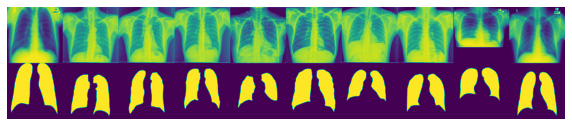

In [6]:
image_set = np.hstack((images[:10]))
mask_set = np.hstack((masks[:10]))
display_set=np.vstack((image_set,mask_set))
plt.figure(figsize=(10,4))
plt.imshow(display_set)
plt.axis('off')
plt.show()

In [7]:
from keras import backend as keras
from keras.models import Model
from keras.models import Input
from keras.models import load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.layers import Conv2DTranspose
from keras.optimizers import Adam

Using TensorFlow backend.


In [8]:
#understanding the neural network

# conv1= conv2D(32,3,padding='same', activation='relu')(input_img)
# conv1= conv2D(32, 3, padding='same', activation='relu')(conv1)
# p1= Maxpooling2D(pool_size=(2,2))(conv1)

# conv2= conv2D(64,3,padding='same', activation='relu')(p1)
# conv2= conv2D(64, 3, padding='same', activation='relu')(conv2)
# p2= Maxpooling2D(pool_size=(2,2))(conv2)

# conv3= conv2D(128,3,padding='same', activation='relu')(p2)
# conv3= conv2D(128, 3, padding='same', activation='relu')(conv3)
# p3= Maxpooling2D(pool_size=(2,2))(conv3)

# conv4= conv2D(256,3,padding='same', activation='relu')(p3)
# conv4= conv2D(256, 3, padding='same', activation='relu')(conv4)
# p4= Maxpooling2D(pool_size=(2,2))(conv4)

# conv5= conv2D(512,3,padding='same', activation='relu')(p4)
# conv5= conv2D(512, 3, padding='same', activation='relu')(conv5)

# up6= conv2D(512,2,activation='relu', padding='same')(UpSampling2D(size=(2,2))(conv5))
# merge6= concantenate([conv4,up6],axis=3)
# conv6=conv2D(512,3,acitvation='relu',padding='same')(merge6)
# conv6=conv2D(512,3,acitvation='relu',padding='same')(conv6)

# up7=conv2D(256, 2, activation='relu', padding='same')(UpSample2D(size=(2,2))(conv6))
# merge7=concantenate([conv3,up7], axis = 3)
# conv7=conv2D(256, 3, activation='relu', padding='same')(merge7)
# conv7=conv2D(256, 3, activation='relu', padding='same')(conv7)

# up8=conv2D(128, 2, activation='relu', padding='same')(UpSample2D(size=(2,2))(conv7))
# merge8=concantenate([conv2,up8], axis = 3)
# conv8=conv2D(128, 3, activation='relu', padding='same')(merge8)
# conv8=conv2D(128, 3, activation='relu', padding='same')(conv8)

# up9=conv2D(64, 2, activation='relu', padding='same')(UpSample2D(size=(2,2))(conv8))
# merge9=concantenate([conv1,up9], axis = 3)
# conv9=conv2D(64, 3, activation='relu', padding='same')(merge9)
# conv9=conv2D(64, 3, activation='relu', padding='same')(conv9)

# conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)



In [9]:
def conv_block(filters,inputs,ret_pool=True):
    
    conv = Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    conv = Conv2D(filters, (3, 3), activation='relu', padding='same')(conv)
    if ret_pool:
        pool = MaxPooling2D(pool_size=(2, 2))(conv)
        return conv,pool
    else:
        return conv
    
def concat_block(filters,conv1,conv2):

    up = concatenate([Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(conv1), conv2], axis=3)
    conv = Conv2D(filters, (3, 3), activation='relu', padding='same')(up)
    conv = Conv2D(filters, (3, 3), activation='relu', padding='same')(conv)
    return conv

def build_model():
    input_size=(512,512,1)
    inputs = Input(input_size)
    
    conv1, pool1 = conv_block(32,inputs)
    conv2, pool2 = conv_block(64,pool1)
    conv3, pool3 = conv_block(128,pool2)
    conv4, pool4 = conv_block(256,pool3)
    conv5 = conv_block(512,pool4,ret_pool=False)
    
    conv6 = concat_block(256,conv5,conv4)
    conv7 = concat_block(128,conv6,conv3)
    conv8 = concat_block(64,conv7,conv2)
    conv9 = concat_block(32,conv8,conv1)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [10]:
def dice_coef(inputs, prediction):
    input_d = keras.flatten(inputs)
    prediction_d = keras.flatten(prediction)
    intersection = keras.sum(input_d * prediction_d)
    return (2. * intersection + 1) / (keras.sum(input_d) + keras.sum(prediction_d) + 1)

def dice_coef_loss(inputs, prediction):
    return -dice_coef(inputs, prediction)

In [11]:
model = build_model()
model.compile(optimizer=Adam(lr=0.0005), loss=dice_coef_loss, metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [12]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, 
                                   mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)

early = EarlyStopping(monitor="val_loss", mode="min", patience=10)
callbacks = [checkpoint, early, reduceLR]

In [13]:
from sklearn.model_selection import train_test_split


dim=512
images = np.array(images).reshape(len(images),dim,dim,1)
masks = np.array(masks).reshape(len(masks),dim,dim,1)



train_images, validation_images, train_masks, validation_masks = train_test_split((images-127.0)/127.0, 
                                                            (masks>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_images, test_images, train_masks, test_masks = train_test_split(train_images,train_masks,
                                                            test_size = 0.1, 
                                                            random_state = 2018)

# x2 = np.flip(train_images , axis = 2)
# y2 = np.flip(train_masks , axis = 2)
# train_images= np.append(train_images, x2,axis=0)
# train_masks = np.append(train_masks, y2,axis=0)
# print(train_images.shape,train_masks.shape )

history = model.fit(x = train_images, y = train_masks, batch_size = 16,
                          validation_data =(test_images,test_masks), epochs = 3,
                          callbacks=callbacks)

Train on 569 samples, validate on 64 samples
Epoch 1/3
569/569 [==============================] - 1818s 3s/step - loss: -0.4930 - dice_coef: 0.4914 - binary_accuracy: 0.7154 - val_loss: -0.7247 - val_dice_coef: 0.7247 - val_binary_accuracy: 0.8459

Epoch 00001: val_loss improved from inf to -0.72467, saving model to cxr_reg_weights.best.hdf5
Epoch 2/3
569/569 [==============================] - 1675s 3s/step - loss: -0.7288 - dice_coef: 0.7273 - binary_accuracy: 0.8450 - val_loss: -0.8429 - val_dice_coef: 0.8429 - val_binary_accuracy: 0.9126

Epoch 00002: val_loss improved from -0.72467 to -0.84289, saving model to cxr_reg_weights.best.hdf5
Epoch 3/3
569/569 [==============================] - 1707s 3s/step - loss: -0.8367 - dice_coef: 0.8371 - binary_accuracy: 0.9171 - val_loss: -0.8843 - val_dice_coef: 0.8843 - val_binary_accuracy: 0.9420

Epoch 00003: val_loss improved from -0.84289 to -0.88428, saving model to cxr_reg_weights.best.hdf5


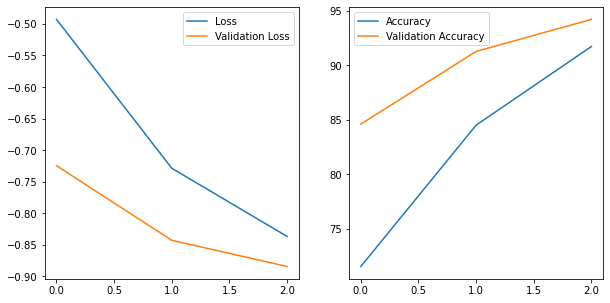

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(history.history['loss'], '-', label = 'Loss')
ax1.plot(history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(history.history['binary_accuracy']), '-', label = 'Accuracy')
ax2.plot(100*np.array(history.history['val_binary_accuracy']), '-', label = 'Validation Accuracy')
ax2.legend()

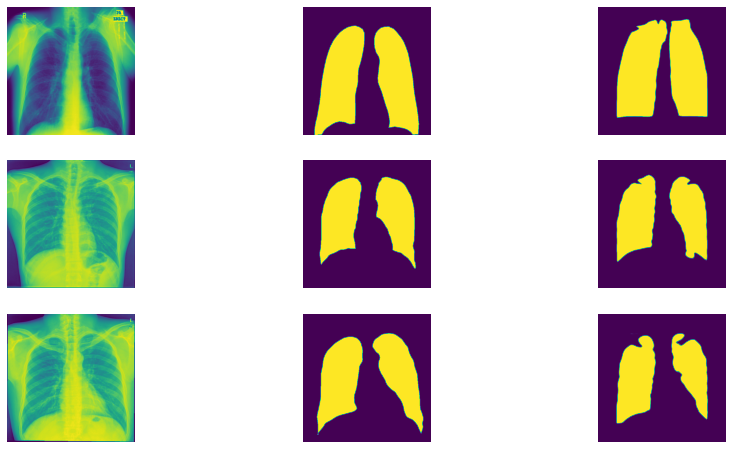

In [15]:
pred_random_set = np.random.randint(1,validation_images.shape[0],10)
preds = model.predict(validation_images)

plt.figure(figsize=(15,8))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_images[pred_random_set[i]]))
    plt.xlabel("Image")
    plt.axis('off')
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_masks[pred_random_set[i]]))
    plt.xlabel("Mask")
    plt.axis('off')
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_random_set[i]]))
    plt.xlabel("Prediction")
    plt.axis('off')